# Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid
from torch.autograd import Variable

# Import Data

In [2]:
train = pd.read_csv("./data/train.csv", dtype=np.float32) # import only train data for trivial modelling
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Convert CSV to Tensors

Train Features Shape: torch.Size([26880, 1, 28, 28])
Validation Features Shape: torch.Size([6720, 1, 28, 28])
Test Features Shape: torch.Size([8400, 1, 28, 28])




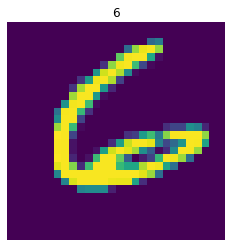

In [3]:
train_features = train.loc[:, train.columns != "label"].values / 255
train_features = train_features.reshape((len(train), 1, 28, 28))
train_labels = train["label"].values

train_features, test_features, train_labels, test_labels = train_test_split(train_features, train_labels,
                                                                           test_size=0.2, random_state=42, stratify=train_labels)
train_features, val_features, train_labels, val_labels = train_test_split(train_features, train_labels,
                                                                           test_size=0.2, random_state=42, stratify=train_labels)

train_features = torch.from_numpy(train_features)
train_labels = torch.from_numpy(train_labels).type(torch.LongTensor)

val_features = torch.from_numpy(val_features)
val_labels = torch.from_numpy(val_labels).type(torch.LongTensor)

test_features = torch.from_numpy(test_features)
test_labels = torch.from_numpy(test_labels).type(torch.LongTensor)

print("Train Features Shape: {}".format(train_features.shape))
print("Validation Features Shape: {}".format(val_features.shape))
print("Test Features Shape: {}\n\n".format(test_features.shape))

plt.imshow(train_features.numpy()[0, :].reshape(28,28))
plt.axis("off")
plt.title(str(train_labels.numpy()[0]))
plt.show()

# Torch Dataset and DataLoader

In [4]:
torch.manual_seed(42)
BATCH_SIZE = 10

train = torch.utils.data.TensorDataset(train_features,train_labels)
val = torch.utils.data.TensorDataset(val_features,val_labels)

train_loader = DataLoader(train, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val, batch_size = BATCH_SIZE, shuffle = True)

# CNN

In [5]:
def conv2d_then_maxpool2d(x):
    return (x-2) /2 

num_neurons = math.floor(conv2d_then_maxpool2d(conv2d_then_maxpool2d(28)))

class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(num_neurons*num_neurons*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, num_neurons*num_neurons*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [6]:
torch.manual_seed(42)
CNNmodel = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNNmodel.parameters(), lr=0.001)
CNNmodel

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

# Train CNN

In [7]:
epochs = 10

train_losses = []
val_losses = []
train_correct = []
val_correct = []

for i in range(epochs):
    CNNmodel.train()
    trn_corr = 0
    val_corr = 0
    
    trn_loss = 0
    val_loss = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = CNNmodel(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        trn_loss += loss.item()

        # Print interim results
        if b%200 == 0:
            print("Epoch: {}\tBatch: {}\tLoss: {}\tAccuracy: {}"\
                 .format(i, b, loss.item(), trn_corr.item() / (b*BATCH_SIZE)))

    train_losses.append(trn_loss / len(train_features))
    train_correct.append(trn_corr.item() / len(train_features))

    # Run the testing batches
    CNNmodel.eval()
    with torch.no_grad():
        for b, (X_test, y_val) in enumerate(val_loader):
            # Apply the model
            y_val_pred = CNNmodel(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val_pred.data, 1)[1] 
            val_corr += (predicted == y_val).sum()

            loss = criterion(y_val_pred, y_val)
            val_loss += loss.item()
            
    val_losses.append(val_loss / len(val_features))
    val_correct.append(val_corr.item() / len(val_features))

Epoch: 0	Batch: 200	Loss: 0.550989031791687	Accuracy: 0.5905
Epoch: 0	Batch: 400	Loss: 0.38097310066223145	Accuracy: 0.722
Epoch: 0	Batch: 600	Loss: 0.11503608524799347	Accuracy: 0.78
Epoch: 0	Batch: 800	Loss: 0.12017730623483658	Accuracy: 0.812625
Epoch: 0	Batch: 1000	Loss: 0.06634638458490372	Accuracy: 0.8368
Epoch: 0	Batch: 1200	Loss: 0.16992244124412537	Accuracy: 0.8535833333333334
Epoch: 0	Batch: 1400	Loss: 0.0072724102064967155	Accuracy: 0.8662857142857143
Epoch: 0	Batch: 1600	Loss: 0.7162083983421326	Accuracy: 0.87575
Epoch: 0	Batch: 1800	Loss: 0.07965947687625885	Accuracy: 0.8832777777777778
Epoch: 0	Batch: 2000	Loss: 0.018856855109333992	Accuracy: 0.8901
Epoch: 0	Batch: 2200	Loss: 0.009889531880617142	Accuracy: 0.8958636363636364
Epoch: 0	Batch: 2400	Loss: 0.028292987495660782	Accuracy: 0.90075
Epoch: 0	Batch: 2600	Loss: 0.046064592897892	Accuracy: 0.9048846153846154
Epoch: 1	Batch: 200	Loss: 0.05635964870452881	Accuracy: 0.9705
Epoch: 1	Batch: 400	Loss: 1.0323784351348877	Acc

Epoch: 9	Batch: 200	Loss: 0.02131497673690319	Accuracy: 0.994
Epoch: 9	Batch: 400	Loss: 0.0013912469148635864	Accuracy: 0.99575
Epoch: 9	Batch: 600	Loss: 0.0003377714310772717	Accuracy: 0.9941666666666666
Epoch: 9	Batch: 800	Loss: 0.0001974196929950267	Accuracy: 0.9945
Epoch: 9	Batch: 1000	Loss: 2.515293317628675e-06	Accuracy: 0.9942
Epoch: 9	Batch: 1200	Loss: 1.938229070219677e-05	Accuracy: 0.9943333333333333
Epoch: 9	Batch: 1400	Loss: 1.9752042135223746e-05	Accuracy: 0.9942142857142857
Epoch: 9	Batch: 1600	Loss: 0.004826757125556469	Accuracy: 0.994
Epoch: 9	Batch: 1800	Loss: 0.0004912684671580791	Accuracy: 0.9938888888888889
Epoch: 9	Batch: 2000	Loss: 0.05712053179740906	Accuracy: 0.9941
Epoch: 9	Batch: 2200	Loss: 0.12808331847190857	Accuracy: 0.9937727272727273
Epoch: 9	Batch: 2400	Loss: 0.08377601206302643	Accuracy: 0.99375
Epoch: 9	Batch: 2600	Loss: 0.01185671053826809	Accuracy: 0.9938461538461538


# Plot Loss and Accuracy

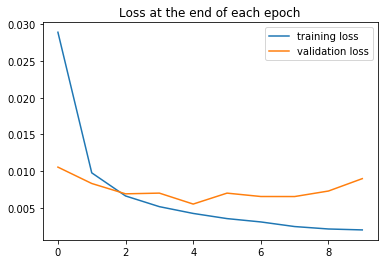

In [8]:
plt.plot(train_losses, label='training loss')
plt.plot(val_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend()

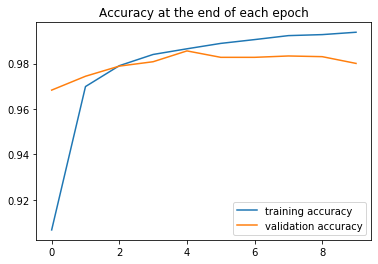

In [9]:
plt.plot(train_correct, label='training accuracy')
plt.plot(val_correct, label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

# Save Model

In [10]:
torch.save(CNNmodel, 'MNIST_model.pt')

/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type ConvolutionalNetwork. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# Load Model

In [11]:
CNNmodel = torch.load('MNIST_model.pt')
CNNmodel

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

# Evaluate Test Data

In [12]:
test = torch.utils.data.TensorDataset(test_features,test_labels)
test_loader = DataLoader(test, batch_size=BATCH_SIZE, shuffle=False)

In [13]:
CNNmodel.eval()
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_loader:
        y_pred = CNNmodel(X_test)
        predicted = torch.max(y_pred,1)[1]
        correct += (predicted == y_test).sum()
print("Test Accuracy: {}".format(correct.item() / len(test_features)))

Test Accuracy: 0.9805952380952381
